### INIT
0. project clone
```bash
    git clone https://github.com/zllrunning/face-parsing.PyTorch.git
    cd face-parsing.PyTorch
```

#### loading library

In [1]:
import cv2
import yaml
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn import functional as F

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

### model loading
- 이때, model은 여기서 제공하는 model.py로 대체

In [2]:
from model import BiSeNet

PRETRAINED_WEIGHT = '/root/face-parsing.PyTorch/pretrained_model/79999_iter.pth'

def load_model_for_inference():
    # define model
    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    # loading pretrained weight
    net.load_state_dict(torch.load(PRETRAINED_WEIGHT))
    net.eval()
    print('모델 로딩 완')
    
    return net

#### Conversion code

In [4]:
def model_conversion(myModel, dummy_inputs, onnx_model_pth, onnx_quant_pth):

    # onnx conversion
    torch.onnx.export(
        model = myModel,                            # 실행될 모델
        args = tuple(dummy_inputs.values()),        # 모델 입력값(tuple or 여러 입력값)
        f = onnx_model_pth,                     # 모델 저장 경로
        export_params=True,                 # 모델 파일 안에 학습된 모델 가중치 저장 여부
        opset_version=13,                   # 모델 변환할 때 사용할 onnx 버전
        do_constant_folding = True,         # 최적화시 상수폴딩 사용할지 여부
        input_names=list(dummy_inputs.keys()),
        output_names    =   ["output"],
        dynamic_axes    =   {
            'input'     : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
            'output'    : {0 : 'batch_size'}
        }
    ) 

    # model quantization
    quantize_dynamic(
        model_input     =   onnx_model_pth,
        model_output    =   onnx_quant_pth,
        per_channel     =   False,
        reduce_range    =   False,
        weight_type     =   QuantType.QUInt8,
    )

In [5]:
# 1. model loading
model = load_model_for_inference()

모델 로딩 완


In [6]:
# onnx 모델 저장 경로
os.makedirs('./onnx_models/', exist_ok=True)
device    = torch.device('cuda')
dummy_inputs = {
    "input" : torch.as_tensor(np.ones([1, 3, 512, 512]), dtype = torch.float32).to(device)
}
# model 변환
onnx_model_path = f'./onnx_models/face_parsing.onnx'
onnx_model_quantized_path = f'./onnx_models/face_parsing_quant.onnx'

# 2. model conversion(onnx & onnx quant)
model_conversion(model, dummy_inputs, onnx_model_path, onnx_model_quantized_path)

#### ONNX-Runtime Test

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import cv2

to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

img = cv2.imread('./origin.png')
img = cv2.resize(img, (512, 512))
img = to_tensor(img)
img = torch.unsqueeze(img, 0)
image_embedding = img.detach().cpu().numpy()
image_embedding.shape

(1, 3, 512, 512)

In [8]:
# loading
ort_session = onnxruntime.InferenceSession(onnx_model_quantized_path, providers=['AzureExecutionProvider'])

# test running
ort_inputs  = {ort_session.get_inputs()[0].name : image_embedding}
ort_outputs = ort_session.run(None, ort_inputs)

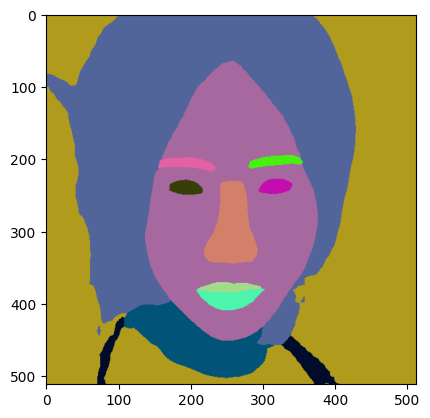

In [9]:
out = ort_outputs[0]
plt.imshow(out)
plt.savefig('./result_plt.png')
#out.type(np.float32)#.shape
cv2.imwrite('./result.png', np.float32(out))